<b><font size="6">Techscape Project</font><a class="anchor"><a id='toc'></a></b><br>

# Import the needed libraries

In [146]:
import pandas as pd
import math
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.stats import chi2_contingency

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

# Import data

In [147]:
techscape = pd.read_csv('train.csv')
techscape.head()

,Access_ID,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Buy
0,102863333,21-Mar-20,0,0.0,0,0.0,3,64.0000,0.0000,0.0667,0.0000,MacOSX,2,Portugal,1,Returner,0
1,103117814,20-May-20,0,0.0,0,0.0,23,684.5000,0.0217,0.0449,0.0000,Windows,2,France,6,Returner,0
2,103201891,4-Dec-20,0,0.0,0,0.0,8,95.0000,0.0250,0.0583,0.0000,Windows,4,Italy,1,Returner,0
3,103226087,22-Dec-20,0,0.0,0,0.0,9,608.7500,0.0000,0.0250,42.4225,Windows,2,United Kingdom,2,Returner,1
4,103234445,24-Nov-20,0,0.0,2,386.0,36,1609.9397,0.0000,0.0093,12.5033,Windows,2,Spain,3,Returner,1


In [198]:
techscape['Buy'].value_counts()
##techscape.drop(['Buy','Access_ID'], axis=1, inplace=True)
#techscape.drop('Buy', axis=1, inplace=True)

0    8308
1    1549
Name: Buy, dtype: int64

In [149]:
# Use this cell to check the values of each column 

techscape[techscape.AccountMng_Pages > 8].AccountMng_Pages.value_counts()

9     180
10    127
11     87
12     69
13     47
14     33
15     31
16     19
17     14
18     12
19      5
24      4
22      3
20      2
21      2
23      2
26      1
27      1
Name: AccountMng_Pages, dtype: int64

# Check for missing data

In [150]:
techscape.info()

# There are now missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Access_ID                   9999 non-null   int64  
 1   Date                        9999 non-null   object 
 2   AccountMng_Pages            9999 non-null   int64  
 3   AccountMng_Duration         9999 non-null   float64
 4   FAQ_Pages                   9999 non-null   int64  
 5   FAQ_Duration                9999 non-null   float64
 6   Product_Pages               9999 non-null   int64  
 7   Product_Duration            9999 non-null   float64
 8   GoogleAnalytics_BounceRate  9999 non-null   float64
 9   GoogleAnalytics_ExitRate    9999 non-null   float64
 10  GoogleAnalytics_PageValue   9999 non-null   float64
 11  OS                          9999 non-null   object 
 12  Browser                     9999 non-null   int64  
 13  Country                     9999 

# Change the types of the variables

In [151]:
# ID does not make sense to be a int
techscape.Access_ID = techscape.Access_ID.astype('string') 

# Tranform Date into a datetime format
techscape.Date = pd.to_datetime(techscape.Date)

techscape.OS = techscape.OS.astype('string') 


techscape.Country = techscape.Country.astype('string') 


techscape.Type_of_Visitor = techscape.Type_of_Visitor.astype('string') 


techscape.Type_of_Traffic = techscape.Type_of_Traffic.astype('string') 

techscape.Browser = techscape.Browser.astype('string') 


techscape.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Access_ID                   9999 non-null   string        
 1   Date                        9999 non-null   datetime64[ns]
 2   AccountMng_Pages            9999 non-null   int64         
 3   AccountMng_Duration         9999 non-null   float64       
 4   FAQ_Pages                   9999 non-null   int64         
 5   FAQ_Duration                9999 non-null   float64       
 6   Product_Pages               9999 non-null   int64         
 7   Product_Duration            9999 non-null   float64       
 8   GoogleAnalytics_BounceRate  9999 non-null   float64       
 9   GoogleAnalytics_ExitRate    9999 non-null   float64       
 10  GoogleAnalytics_PageValue   9999 non-null   float64       
 11  OS                          9999 non-null   string      

In [152]:
# Separate the metric variables from the non metric ones 
#non_metric_features = ['Access_ID', 'Date',"OS", "Browser", "Country", "Type_of_Traffic", "Type_of_Visitor", 'Buy'] 
#metric_features = techscape.columns.drop(non_metric_features).to_list()

metric_features = techscape.select_dtypes(include=np.number).set_index(techscape.index).columns.to_list()
non_metric_features = techscape.select_dtypes(exclude=np.number).set_index(techscape.index).columns.to_list()

non_metric_features

['Access_ID',
 'Date',
 'OS',
 'Browser',
 'Country',
 'Type_of_Traffic',
 'Type_of_Visitor']

# Check for incoherencies in the data


In [153]:
# Date variable
print(f'Date of the web visit varies from {techscape.Date.min()} and {techscape.Date.max()}, excluding the month of April.')

Date of the web visit varies from 2020-02-01 00:00:00 and 2020-12-31 00:00:00, excluding the month of April.


In [154]:
# Pages and Duration variables

# usually, it doeesn´t make sense that Pages > 0 and Duration = 0. However, there are too many observations like that,
# so, in instead of removing them, we decided to convert (duration = 0, pages=1)  --> (duration = 1, pages=1)

#techscape[(techscape['AccountMng_Pages']==0) & (techscape['AccountMng_Duration']!=0) ] # --> 0
account_index = techscape[(techscape['AccountMng_Pages']>1) & (techscape['AccountMng_Duration']==0) ].index  # --> 3
len(account_index)
techscape.drop(account_index, axis=0, inplace=True)
techscape.loc[techscape['AccountMng_Duration']==0,'AccountMng_Duration'] = 1
techscape

#techscape[(techscape['FAQ_Pages']==0) & (techscape['FAQ_Duration']!=0) ] # --> 0
faq_index = techscape[(techscape['FAQ_Pages']>1) & (techscape['FAQ_Duration']==0) ].index # --> 9
len(faq_index)
techscape.drop(faq_index, axis=0, inplace=True)
techscape.loc[techscape['FAQ_Duration']==0,'FAQ_Duration'] = 1
techscape

#techscape[(techscape['Product_Pages']==0) & (techscape['Product_Duration']!=0) ] # --> 0
product_index = techscape[(techscape['Product_Pages']>1) & (techscape['Product_Duration']==0) ].index # --> 130
len(product_index)
techscape.drop(product_index, axis=0, inplace=True)
techscape.loc[techscape['Product_Duration']==0,'Product_Duration'] = 1
techscape


# Total removed = 3 + 9 + 130 = 142 (1.42%)

,Access_ID,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Buy
0,102863333,2020-03-21,0,1.0,0,1.0,3,64.0000,0.0000,0.0667,0.0000,MacOSX,2,Portugal,1,Returner,0
1,103117814,2020-05-20,0,1.0,0,1.0,23,684.5000,0.0217,0.0449,0.0000,Windows,2,France,6,Returner,0
2,103201891,2020-12-04,0,1.0,0,1.0,8,95.0000,0.0250,0.0583,0.0000,Windows,4,Italy,1,Returner,0
3,103226087,2020-12-22,0,1.0,0,1.0,9,608.7500,0.0000,0.0250,42.4225,Windows,2,United Kingdom,2,Returner,1
4,103234445,2020-11-24,0,1.0,2,386.0,36,1609.9397,0.0000,0.0093,12.5033,Windows,2,Spain,3,Returner,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,798279589,2020-05-08,3,159.0,2,55.5,23,1100.1250,0.0000,0.0111,0.0000,MacOSX,2,Brazil,14,Returner,0
9995,798314158,2020-07-17,6,175.1,0,1.0,3,27.6000,0.0000,0.0111,0.0000,Windows,10,Spain,5,New_Access,0
9996,798339820,2020-03-23,0,1.0,0,1.0,27,644.0000,0.0077,0.0519,0.0000,MacOSX,2,France,3,Returner,0
9997,798371242,2020-05-16,0,1.0,0,1.0,53,715.5000,0.0226,0.0363,0.0000,Windows,2,Italy,3,Returner,0


# Deal with the outliers

In [155]:
# Se descriptive statistics for all the variables
techscape.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Access_ID,9857,9857,735733377,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date,9857,305,2020-05-25 00:00:00,118,2020-02-01,2020-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AccountMng_Pages,9857.0,NaN,NaN,NaN,NaT,NaT,2.353454,3.352719,0.0,0.0,1.0,4.0,27.0
AccountMng_Duration,9857.0,NaN,NaN,NaN,NaT,NaT,82.729758,180.498648,1.0,1.0,9.5,94.0,3398.75
FAQ_Pages,9857.0,NaN,NaN,NaN,NaT,NaT,0.513442,1.28642,0.0,0.0,0.0,0.0,24.0
FAQ_Duration,9857.0,NaN,NaN,NaN,NaT,NaT,35.857203,140.539521,1.0,1.0,1.0,1.0,2549.375
Product_Pages,9857.0,NaN,NaN,NaN,NaT,NaT,32.069494,44.734139,0.0,8.0,18.0,38.0,705.0
Product_Duration,9857.0,NaN,NaN,NaN,NaT,NaT,1215.836554,1967.18977,0.5,197.0,612.625,1483.55,63973.5222
GoogleAnalytics_BounceRate,9857.0,NaN,NaN,NaN,NaT,NaT,0.020057,0.044845,0.0,0.0,0.0029,0.016,0.2
GoogleAnalytics_ExitRate,9857.0,NaN,NaN,NaN,NaT,NaT,0.041122,0.045789,0.0,0.0142,0.025,0.0481,0.2


In [156]:
#techscape[['AccountMng_Pages', 'FAQ_Pages', 'Product_Pages']].describe().T
#techscape[['AccountMng_Duration', 'FAQ_Duration', 'Product_Duration']].describe().T
#techscape[['GoogleAnalytics_BounceRate', 'GoogleAnalytics_ExitRate', 'GoogleAnalytics_PageValue', 'Browser', 'Type_of_Traffic']].describe().T


# AccountMng_Pages appears to have outliers
# Same with FAQ_Pages
# Product_Pages definitely has outliers
# GoogleAnalytics_PageValue appears to have outliers

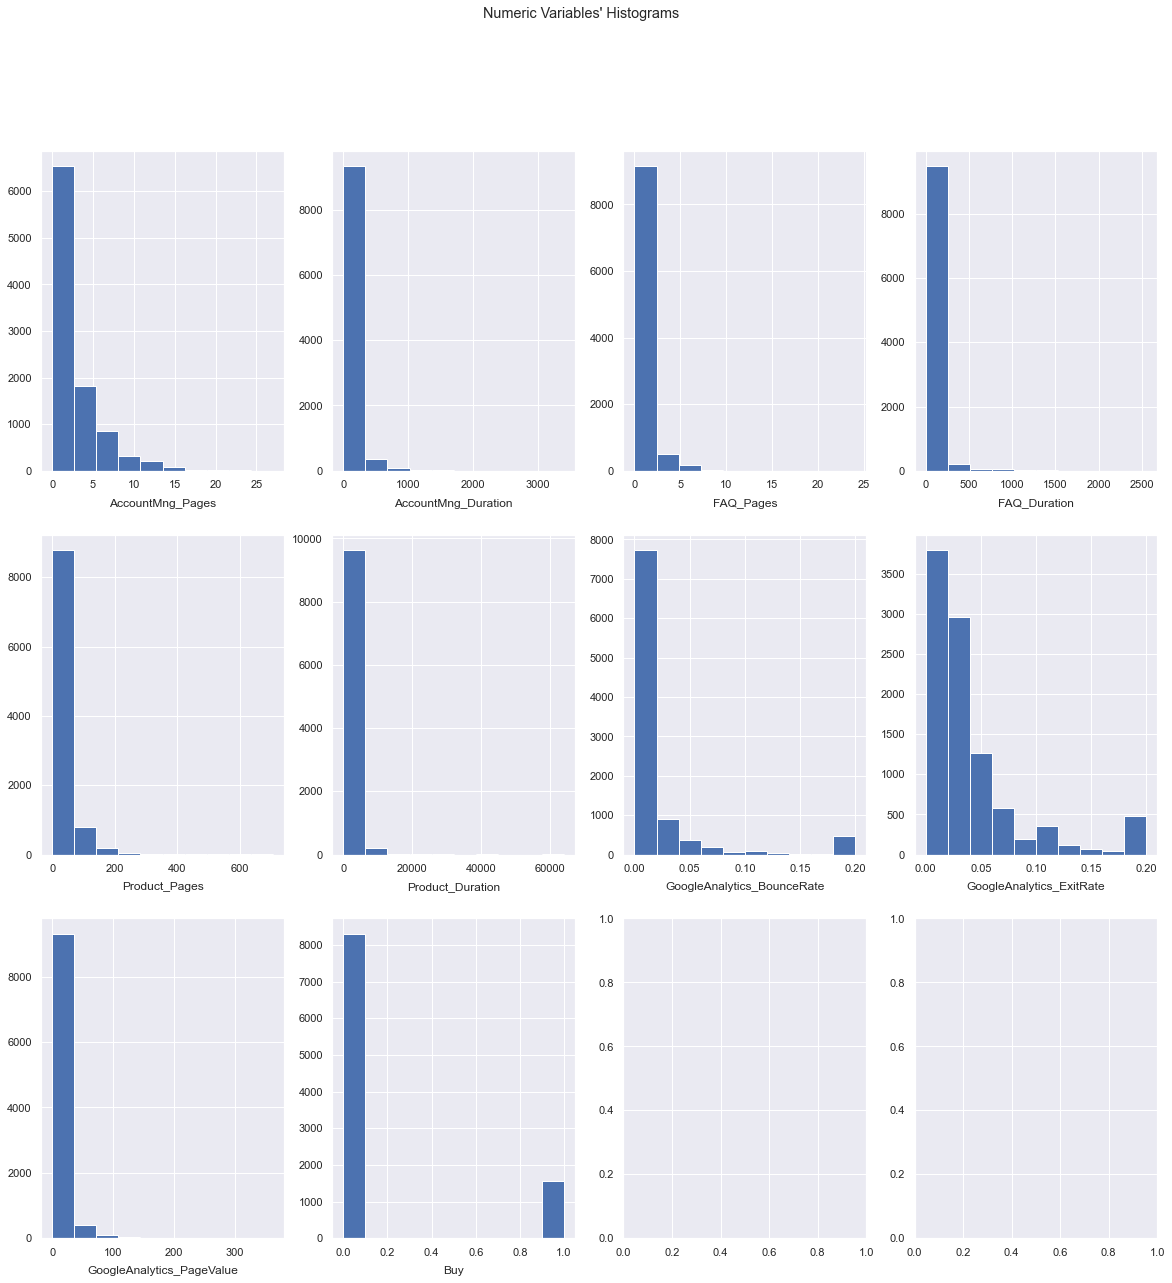

In [157]:
# -----------  Plot the histograms of the numeric variables  -----------

# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(3, math.ceil(len(metric_features) / 3), figsize=(20,20))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    ax.hist(techscape[feat])
    ax.set_title(feat, y=-0.13)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Histograms"

plt.suptitle(title)

plt.show()

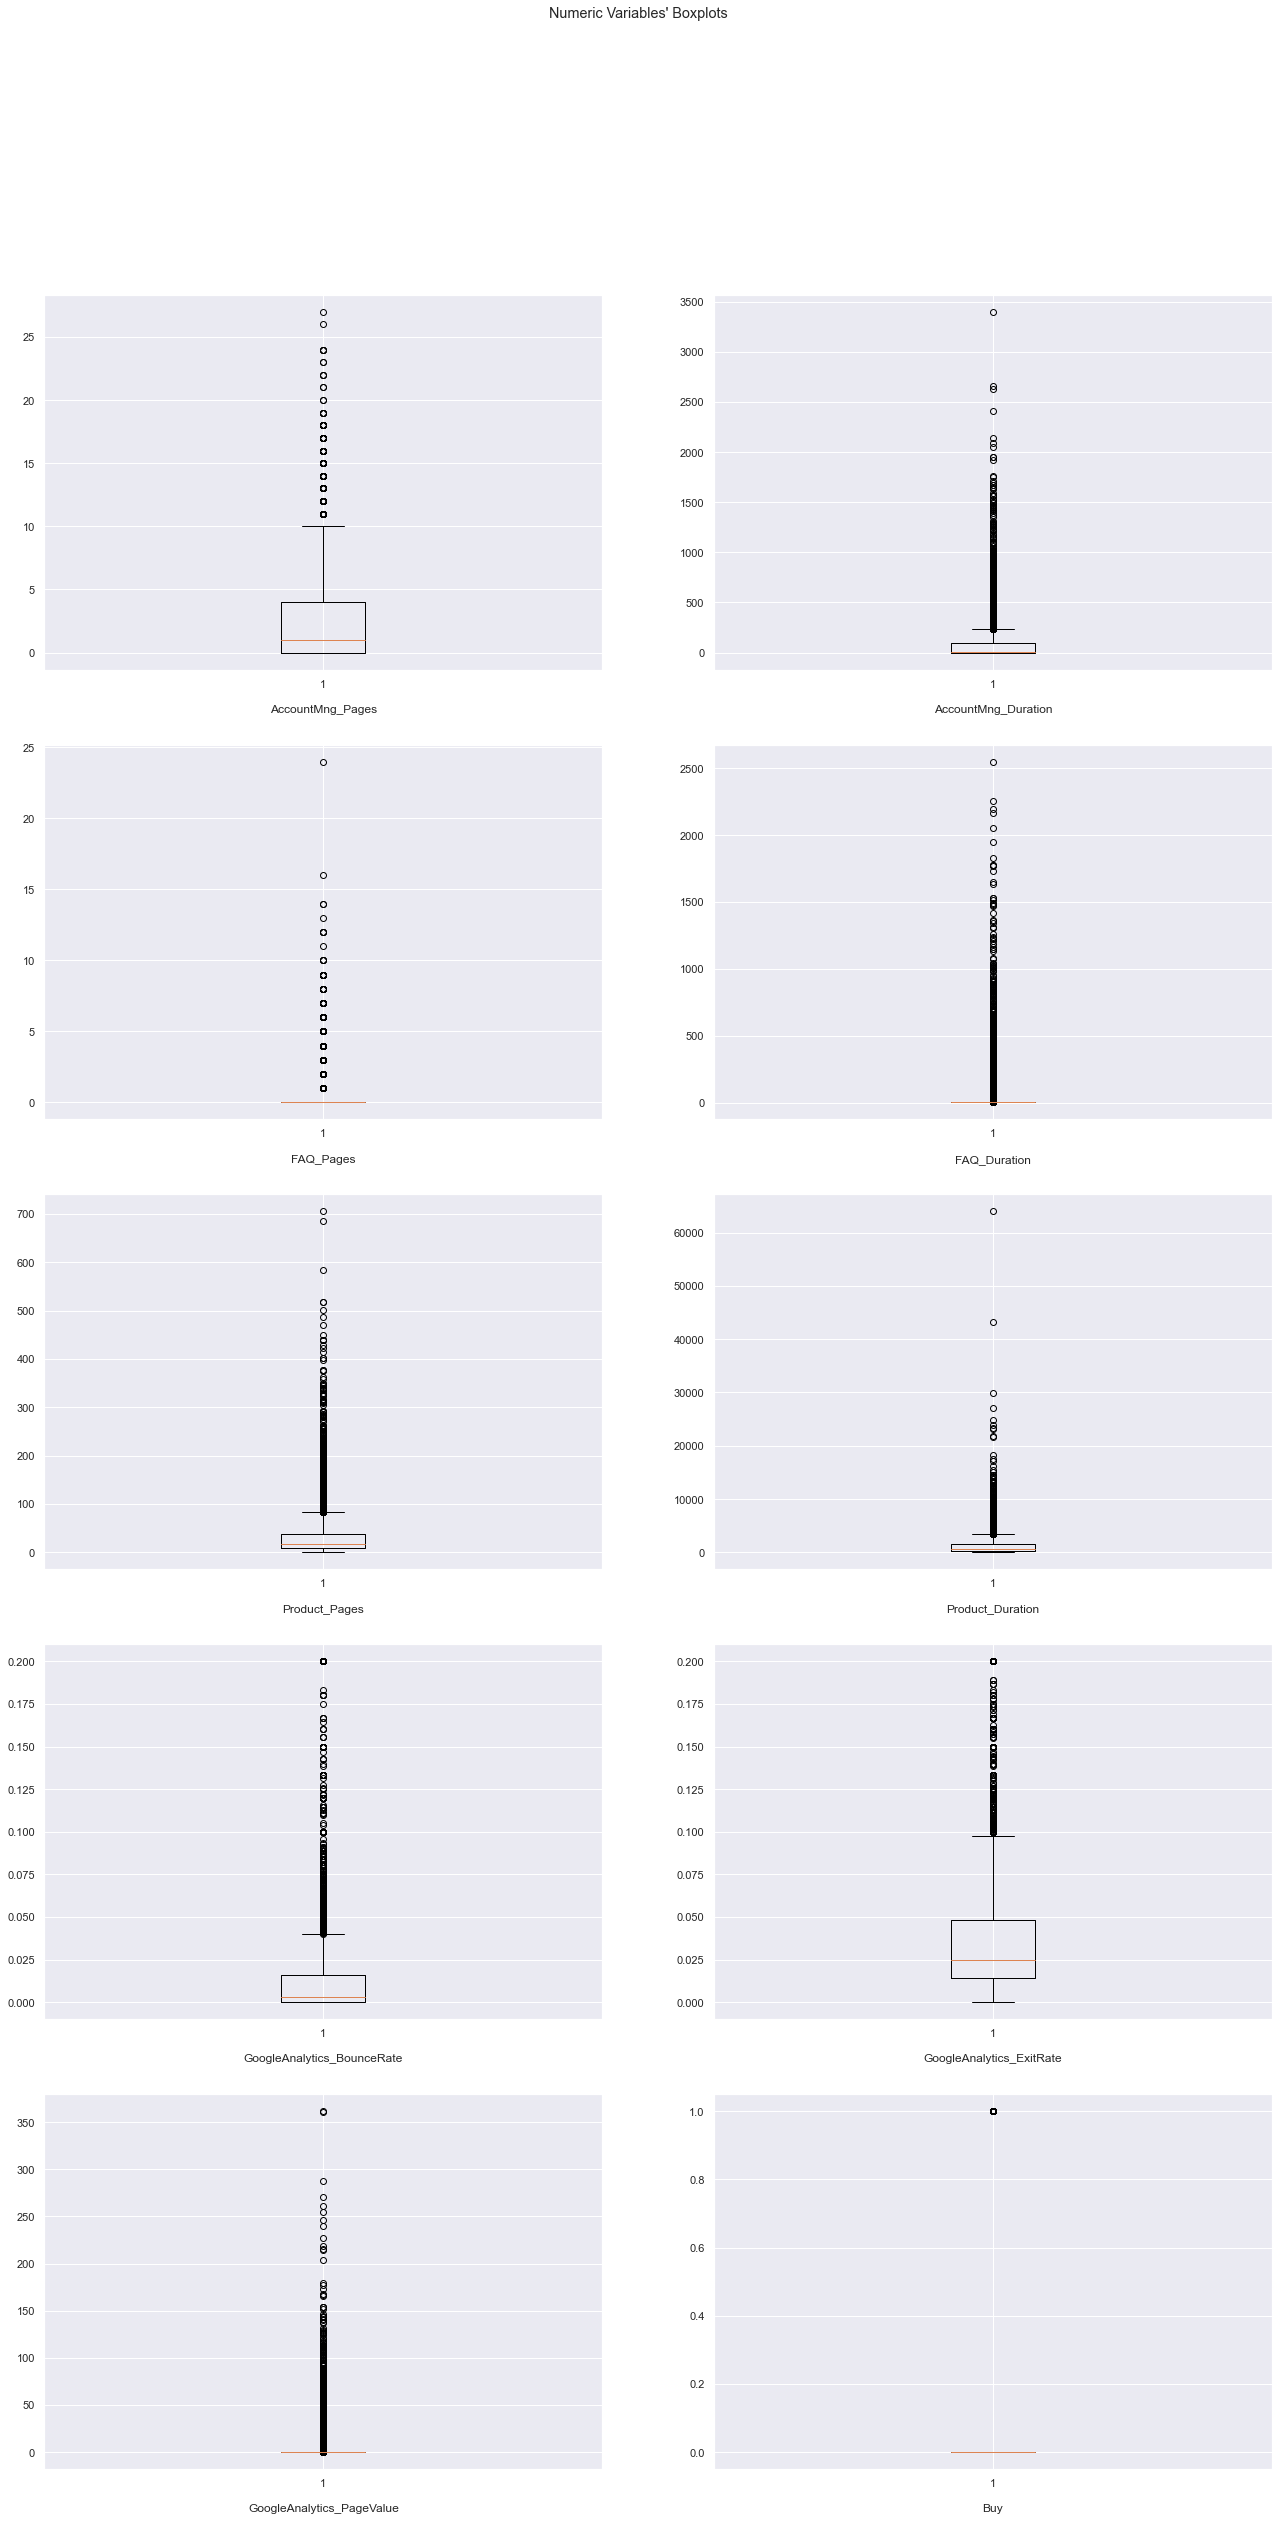

In [158]:
# -----------  Plot the boxplots of the numeric variables  -----------

# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(5, math.ceil(len(metric_features) / 5), figsize=(22, 40))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    ax.boxplot(techscape[feat])
    ax.set_title(feat, y=-0.13)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Boxplots"

plt.suptitle(title)

plt.show()

In [159]:
# This may vary from session to session, and is prone to varying interpretations.
# A simple example is provided below:

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
filters1 = (
    (techscape['GoogleAnalytics_BounceRate']<= 0.1)
    &
    (techscape['GoogleAnalytics_ExitRate']<= 0.1)
    &
    (techscape['GoogleAnalytics_PageValue']<= 80)
    &
    (techscape['AccountMng_Pages']<= 18)  
    &
    (techscape['FAQ_Pages']<=7)
    &
    (techscape['FAQ_Duration']<=700)
    &
    (techscape['FAQ_Duration']<=700)    
)

techscape_1 = techscape[filters1]

perc_outliers1 = np.round((techscape.shape[0] - techscape_1.shape[0]) / techscape.shape[0] * 100, 2)
print(f'Percentage of observations removed: {perc_outliers1}%')

Percentage of observations removed: 10.54%


In [160]:
#techscape[techscape.AccountMng_Pages > 8].AccountMng_Pages.value_counts()

In [161]:
#upper_lim

In [162]:
# ------------------  Interquantile method ------------------

#q25 = techscape.quantile(.25)
#q75 = techscape.quantile(.75)
#iqr = (q75 - q25)

techscape_mean, techscape_std = np.mean(techscape), np.std(techscape)

# We can change the number of stds
upper_lim = techscape_mean + 5 * techscape_std   
lower_lim = techscape_mean - 5 * techscape_std

filters2 = []

for metric in metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    
    filters2.append(techscape[metric].between(llim, ulim, inclusive=True))
    


filters2 = pd.Series(np.all(filters2, 0))
filters2=filters2.values


techscape_2 = techscape[filters2]

perc_outliers2 = np.round((techscape.shape[0] - techscape_2.shape[0]) / techscape.shape[0] * 100, 2)
print(f'Percentage of observations removed: {perc_outliers2}%')

Percentage of observations removed: 3.48%


In [163]:
# Filter 3 -- KMeans
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

data = techscape[metric_features]

In [164]:
# Get the inertia values from 2 to 15 clusters
nclusters=np.arange(2,15)
inertia = []

for i in nclusters:
    km = KMeans(n_clusters = i+1)
    clusters=km.fit_predict(data)
    inertia.append(km.inertia_)

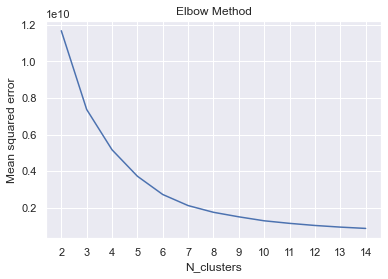

In [165]:
# Plot the Elbow Graphic
plt.plot(nclusters, inertia)
plt.xticks(nclusters)

plt.xlabel("N_clusters")
plt.ylabel("Mean squared error")
plt.title("Elbow Method")
plt.show()

In [166]:
# By looking into the elbow graphic we decided to select 4 centroids

# kmeans model, setting k = 4
km = KMeans(n_clusters = 4)
clusters=km.fit_predict(data)

# obtaining the centers of the clusters
centroids = km.cluster_centers_

# points array will be used to reach the index easy
points = np.empty((0,len(data.loc[0,:])), float)

# distances will be used to calculate outliers
distances = np.empty((0,data.shape[1]), float)

# getting points and distances
for i, center_elem in enumerate(centroids):
    # cdist is used to calculate the distance between center and other points
    distances = np.append(distances, cdist([center_elem],data[clusters == i], 'euclidean')) 
    points = np.append(points, data[clusters == i], axis=0)
    
percentile = 80
# getting outliers whose distances are greater than some percentile
outliers = points[np.where(distances > np.percentile(distances, percentile))]

In [167]:
# Transform the dataframe into an ndarray
datanp = data.values

# Match outliers with each specific row
pairwise_compare = datanp == outliers[:, np.newaxis, :]
filters3 = ~pairwise_compare.all(axis=2).any(axis=0)

techscape_3 = techscape[filters3]

perc_outliers3 = np.round((techscape.shape[0] - techscape_3.shape[0]) / techscape.shape[0] * 100, 2)
print(f'Percentage of observations removed: {perc_outliers3}%')

Percentage of observations removed: 20.01%


In [168]:
techscape_4 = techscape[(filters1 | filters2 | filters3)]

perc_outliers4 = np.round((techscape.shape[0] - techscape_4.shape[0]) / techscape.shape[0] * 100, 2)
print(f'Percentage of outliers removed: {perc_outliers4}%')

Percentage of outliers removed: 1.41%


# Feature Engineering

In [169]:
#techscape['Type_of_Traffic'].value_counts()

In [170]:
# Create new variables

# Create binary variables for operating systems
techscape['Apple'] = techscape['OS'].apply(lambda x: str(1) if x == 'MacOSX' or x == 'iOS' else str(0))  
techscape['Windows'] = techscape['OS'].apply(lambda x: str(1) if x == 'Windows' else str(0))  
techscape['Android'] = techscape['OS'].apply(lambda x: str(1) if x == 'Android' else str(0))


# Create binary variables for countries
techscape['Portugal'] = techscape['Country'].apply(lambda x: str(1) if x == 'Portugal' else str(0)) 
techscape['Iberian_Peninsula'] = techscape['Country'].apply(lambda x: str(1) if x == 'Portugal' or x == 'Spain' else str(0))
techscape['Spain'] = techscape['Country'].apply(lambda x: str(1) if x == 'Spain' else str(0))


# Create binary variables for type of visitors
techscape['Returner'] = techscape['Type_of_Visitor'].apply(lambda x: str(1) if x == 'Returner' else str(0)) 
techscape['New_Access'] = techscape['Type_of_Visitor'].apply(lambda x: str(1) if x == 'New_Access' else str(0))


# Create the total duration of the visits and total number of page visits
techscape['Total_Duration'] = techscape['AccountMng_Duration'] + techscape['FAQ_Duration'] + techscape['Product_Duration']
techscape['Total_Pages'] = techscape['AccountMng_Pages'] + techscape['FAQ_Pages'] + techscape['Product_Pages']

techscape.loc[techscape['Total_Pages']==0,'Total_Pages']=1


# Create the proportion of time on each page type
techscape['PropTime_AccountMng'] = techscape['AccountMng_Duration']/techscape['Total_Duration']
techscape['PropTime_FAQ'] = techscape['FAQ_Duration']/techscape['Total_Duration']
techscape['PropTime_Product'] = techscape['Product_Duration']/techscape['Total_Duration']

# Create the proportion of visited pages of each type
techscape['PropPages_AccountMng'] = techscape['AccountMng_Pages']/techscape['Total_Pages']
techscape['PropPages_FAQ'] = techscape['FAQ_Pages']/techscape['Total_Pages']
techscape['PropPages_Product'] = techscape['Product_Pages']/techscape['Total_Pages']

# Create the average time spent per page and type of page
techscape['AvgTimePerPage'] = techscape['Total_Duration'].div(techscape['Total_Pages'].values)

techscape['AvgTimeOnAccountMng'] = techscape['AccountMng_Duration'].div(techscape['AccountMng_Pages'].values)
techscape['AvgTimeOnFAQ'] = techscape['FAQ_Duration'].div(techscape['FAQ_Pages'].values)
techscape['AvgTimeOnProduct'] = techscape['Product_Duration'].div(techscape['Product_Pages'].values)

techscape.loc[techscape['AccountMng_Pages']==0,'AvgTimeOnAccountMng']=0
techscape.loc[techscape['FAQ_Pages']==0,'AvgTimeOnFAQ']=0
techscape.loc[techscape['Product_Pages']==0,'AvgTimeOnProduct']=0


### avg time per type of page?


# Create the month of the visit
techscape['Month'] = techscape['Date'].dt.month


# Create variable Covid
techscape['Covid'] = techscape['Month'].apply(lambda x: str(1) if x>3 else str(0))


# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! fórmula

#dummy_v = cat_to_num_indep[['Native Continent','MaritalStatusNew', 'LivesWithNew', 'Base Area New',
#                 'Employment Sector New', 'Role New','Groups']].copy()
#dummy_v.head()
#
#dummy = pd.get_dummies(dummy_v, drop_first = True)
#dummy = pd.DataFrame(dummy)
#
#dummy.head(10)


techscape['Traffic2']=techscape['Type_of_Traffic'].apply(lambda x: str(1) if x == '2' else str(0))
techscape['Traffic3']=techscape['Type_of_Traffic'].apply(lambda x: str(1) if x == '3' else str(0)) 
techscape['Traffic4']=techscape['Type_of_Traffic'].apply(lambda x: str(1) if x == '4' else str(0)) 
techscape['Traffic5']=techscape['Type_of_Traffic'].apply(lambda x: str(1) if x == '5' else str(0)) 
techscape['Traffic6']=techscape['Type_of_Traffic'].apply(lambda x: str(1) if x == '6' else str(0)) 
techscape['Traffic7']=techscape['Type_of_Traffic'].apply(lambda x: str(1) if x == '7' else str(0))
techscape['Traffic8']=techscape['Type_of_Traffic'].apply(lambda x: str(1) if x == '8' else str(0)) 
techscape['Traffic9']=techscape['Type_of_Traffic'].apply(lambda x: str(1) if x == '9' else str(0)) 
techscape['Traffic10']=techscape['Type_of_Traffic'].apply(lambda x: str(1) if x == '10' else str(0)) 
techscape['Traffic11']=techscape['Type_of_Traffic'].apply(lambda x: str(1) if x == '11' else str(0)) 
techscape['Traffic12']=techscape['Type_of_Traffic'].apply(lambda x: str(1) if x == '12' else str(0)) 
techscape['Traffic13']=techscape['Type_of_Traffic'].apply(lambda x: str(1) if x == '13' else str(0)) 
techscape['Traffic14']=techscape['Type_of_Traffic'].apply(lambda x: str(1) if x == '14' else str(0)) 
techscape['Traffic15']=techscape['Type_of_Traffic'].apply(lambda x: str(1) if x == '15' else str(0)) 

 
techscape['Browser2']=techscape['Browser'].apply(lambda x: str(1) if x == '2' else str(0))
techscape['Browser3']=techscape['Browser'].apply(lambda x: str(1) if x == '3' else str(0)) 
techscape['Browser4']=techscape['Browser'].apply(lambda x: str(1) if x == '4' else str(0)) 
techscape['Browser5']=techscape['Browser'].apply(lambda x: str(1) if x == '5' else str(0)) 
techscape['Browser6']=techscape['Browser'].apply(lambda x: str(1) if x == '6' else str(0)) 
techscape['Browser7']=techscape['Browser'].apply(lambda x: str(1) if x == '7' else str(0))
techscape['Browser8']=techscape['Browser'].apply(lambda x: str(1) if x == '8' else str(0)) 
techscape['Browser9']=techscape['Browser'].apply(lambda x: str(1) if x == '9' else str(0)) 
techscape['Browser10']=techscape['Browser'].apply(lambda x: str(1) if x == '10' else str(0)) 
techscape['Browser11']=techscape['Browser'].apply(lambda x: str(1) if x == '11' else str(0)) 
techscape['Browser12']=techscape['Browser'].apply(lambda x: str(1) if x == '12' else str(0)) 
techscape['Browser13']=techscape['Browser'].apply(lambda x: str(1) if x == '13' else str(0))


techscape['Feb']=techscape['Browser'].apply(lambda x: str(1) if x == '2' else str(0))
techscape['Mar']=techscape['Browser'].apply(lambda x: str(1) if x == '3' else str(0)) 
techscape['Apr']=techscape['Browser'].apply(lambda x: str(1) if x == '4' else str(0)) 
techscape['May']=techscape['Browser'].apply(lambda x: str(1) if x == '5' else str(0)) 
techscape['Jun']=techscape['Browser'].apply(lambda x: str(1) if x == '6' else str(0)) 
techscape['Jul']=techscape['Browser'].apply(lambda x: str(1) if x == '7' else str(0))
techscape['Aug']=techscape['Browser'].apply(lambda x: str(1) if x == '8' else str(0)) 
techscape['Sep']=techscape['Browser'].apply(lambda x: str(1) if x == '9' else str(0)) 
techscape['Oct']=techscape['Browser'].apply(lambda x: str(1) if x == '10' else str(0)) 
techscape['Nov']=techscape['Browser'].apply(lambda x: str(1) if x == '11' else str(0)) 
techscape['Dec']=techscape['Browser'].apply(lambda x: str(1) if x == '12' else str(0)) 

techscape


,Access_ID,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,...,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,102863333,2020-03-21,0,1.0,0,1.0,3,64.0000,0.0000,0.0667,...,0,0,0,0,0,0,0,0,0,0
1,103117814,2020-05-20,0,1.0,0,1.0,23,684.5000,0.0217,0.0449,...,0,0,0,0,0,0,0,0,0,0
2,103201891,2020-12-04,0,1.0,0,1.0,8,95.0000,0.0250,0.0583,...,0,1,0,0,0,0,0,0,0,0
3,103226087,2020-12-22,0,1.0,0,1.0,9,608.7500,0.0000,0.0250,...,0,0,0,0,0,0,0,0,0,0
4,103234445,2020-11-24,0,1.0,2,386.0,36,1609.9397,0.0000,0.0093,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,798279589,2020-05-08,3,159.0,2,55.5,23,1100.1250,0.0000,0.0111,...,0,0,0,0,0,0,0,0,0,0
9995,798314158,2020-07-17,6,175.1,0,1.0,3,27.6000,0.0000,0.0111,...,0,0,0,0,0,0,0,1,0,0
9996,798339820,2020-03-23,0,1.0,0,1.0,27,644.0000,0.0077,0.0519,...,0,0,0,0,0,0,0,0,0,0
9997,798371242,2020-05-16,0,1.0,0,1.0,53,715.5000,0.0226,0.0363,...,0,0,0,0,0,0,0,0,0,0


In [171]:
techscape.drop('OS', axis=1, inplace=True)
techscape.drop('Country', axis=1, inplace=True)
techscape.drop('Type_of_Visitor', axis=1, inplace=True)
techscape.drop('Browser', axis=1, inplace=True)
techscape.drop('Type_of_Traffic', axis=1, inplace=True)
techscape.drop('Date', axis=1, inplace=True)
#techscape.drop('Access_ID', axis=1, inplace=True)
techscape.drop('Month', axis=1, inplace=True)

# Data Partition



In [172]:
techscape.head(3)

,Access_ID,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,...,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,102863333,0,1.0,0,1.0,3,64.0,0.0000,0.0667,0.0,...,0,0,0,0,0,0,0,0,0,0
1,103117814,0,1.0,0,1.0,23,684.5,0.0217,0.0449,0.0,...,0,0,0,0,0,0,0,0,0,0
2,103201891,0,1.0,0,1.0,8,95.0,0.0250,0.0583,0.0,...,0,1,0,0,0,0,0,0,0,0


In [173]:
#techscape.describe().T

In [174]:
# -------------- DATA PARTITION --------------

# Define data as all the independent variables
data = techscape.drop(['Buy'], axis=1)
# Define target as the dependent variable
target = techscape['Buy']

## -----------------------
#
#from sklearn.model_selection import train_test_split
#
#X_train, X_val, y_train, y_val = train_test_split(data, target, train_size=0.75, stratify = target, random_state=5)
## Train 0.75 || Valid 0.25
## Stratify so we have the same values in target in the train and val datasets
#
## -----------------------
#
#X_train_metric = X_train.select_dtypes(include=np.number).set_index(X_train.index)
#X_train_non_metric = X_train.select_dtypes(exclude=np.number).set_index(X_train.index)
## DO IT for validation
#X_val_metric = X_val.select_dtypes(include=np.number).set_index(X_val.index)
#X_val_non_metric = X_val.select_dtypes(exclude=np.number).set_index(X_val.index)
#
#### Usam binárias como numéricas ??

In [175]:
# -------------- SCALLING --------------

#from sklearn.preprocessing import MinMaxScaler
#
#scaler = MinMaxScaler().fit(X_train_metric)
#X_train_metric_scaled = scaler.transform(X_train_metric) # this will return an array
#
### Convert the array to a pandas dataframe
#X_train_metric_scaled = pd.DataFrame(X_train_metric_scaled, columns = X_train_metric.columns).set_index(X_train.index)
#display(X_train_metric_scaled.head(3))
#
#X_val_metric_scaled = scaler.transform(X_val_metric)
#X_val_metric_scaled = pd.DataFrame(X_val_metric_scaled, columns = X_val_metric.columns).set_index(X_val.index)
#display(X_val_metric_scaled.head(3))


# Feature Selection

In [176]:
# Get all the metric and non metric variables
data_metric = data.select_dtypes(include=np.number).set_index(data.index)
data_non_metric = data.select_dtypes(exclude=np.number).set_index(data.index)

# Create a KFold with 10 splits
kf = KFold(n_splits=10)

In [59]:
# ----------------------------- RFE -----------------------------
fold = 1

for train_index, val_index in kf.split(data_metric):
        
        # Data Partition
        X_train, X_val = data_metric.iloc[train_index], data_metric.iloc[val_index]
        y_train, y_val = target.iloc[train_index], target.iloc[val_index]
        
        # Scaling the data with MinMaxScaler
        scaler = MinMaxScaler().fit(X_train)
        
        X_train_metric_scaled = scaler.transform(X_train) # this will return an array
        X_train_metric_scaled = pd.DataFrame(X_train_metric_scaled, columns = X_train.columns)#.set_index(X_train.index)

        X_val_metric_scaled = scaler.transform(X_val)
        X_val_metric_scaled = pd.DataFrame(X_val_metric_scaled, columns = X_val.columns)#.set_index(X_val.index)
        
        
        # CODE FOR RFE
        nof_list = np.arange(1,len(data_metric.columns)+1)  # Array from 1 to 21           
        high_score = 0
        nof = 0  # Variable to store the optimum number of features
        
        for n in nof_list:
            
            model = LogisticRegression()
            rfe = RFE(model, n)
            
            X_train_rfe = rfe.fit_transform(X_train_metric_scaled,y_train)
            X_val_rfe = rfe.transform(X_val_metric_scaled)
            
            model.fit(X_train_rfe,y_train)

            score = model.score(X_val_rfe,y_val)
            
            if (score > high_score):
                high_score = score
                nof = n
                selected_features = pd.Series(rfe.support_, index = X_train_metric_scaled.columns, name=f'Partition {fold}')
                
        if fold == 1:
            # Create empty data frame
            rfe_results = pd.DataFrame(index = X_train_metric_scaled.columns)
        
        # Concatenate variables chosen at each partition
        rfe_results = pd.concat((rfe_results, selected_features), axis=1)
        
        print('Pão pão queijo queijo')
        fold+=1

# Add new column with count of True's        
count_rfe_list = []
for index, row in rfe_results.iterrows():
    count = 0
    for elem in row:
        if elem == True:
            count+=1
    count_rfe_list.append(count)

rfe_results['Count'] = count_rfe_list

rfe_results.sort_values(by='Count', ascending=False)

Pão pão queijo queijo
Pão pão queijo queijo
Pão pão queijo queijo
Pão pão queijo queijo
Pão pão queijo queijo
Pão pão queijo queijo
Pão pão queijo queijo
Pão pão queijo queijo
Pão pão queijo queijo
Pão pão queijo queijo


,Partition 1,Partition 2,Partition 3,Partition 4,Partition 5,Partition 6,Partition 7,Partition 8,Partition 9,Partition 10,Count
GoogleAnalytics_PageValue,True,True,True,True,True,True,True,True,True,True,10
GoogleAnalytics_ExitRate,False,True,True,True,True,True,True,True,True,True,9
Total_Pages,False,True,False,False,True,False,False,False,True,False,3
Product_Pages,False,True,False,False,True,False,False,False,True,False,3
Product_Duration,False,True,False,False,True,False,False,False,True,False,3
GoogleAnalytics_BounceRate,False,True,False,False,False,False,False,False,True,False,2
PropPages_AccountMng,False,False,False,False,False,False,False,False,True,False,1
AvgTimeOnAccountMng,False,False,False,False,False,False,False,False,True,False,1
Total_Duration,False,False,False,False,False,False,False,False,True,False,1
PropTime_AccountMng,False,False,False,False,False,False,False,False,True,False,1


In [58]:
# ----------------------------- Lasso -----------------------------
fold = 1

for train_index, val_index in kf.split(data_metric):
        
        # Data Partition
        X_train, X_val = data_metric.iloc[train_index], data_metric.iloc[val_index]
        y_train, y_val = target.iloc[train_index], target.iloc[val_index]
        
        # Scaling the data with MinMaxScaler
        scaler = MinMaxScaler().fit(X_train)
        
        X_train_metric_scaled = scaler.transform(X_train) # this will return an array
        X_train_metric_scaled = pd.DataFrame(X_train_metric_scaled, columns = X_train.columns)#.set_index(X_train.index)

        X_val_metric_scaled = scaler.transform(X_val)
        X_val_metric_scaled = pd.DataFrame(X_val_metric_scaled, columns = X_val.columns)#.set_index(X_val.index)
        
        
        # CODE FOR LASSO
        reg = LassoCV()
        lasso = reg.fit(X_train_metric_scaled, y_train)
        importance = np.abs(lasso.coef_)
        #print(importance)
        
        coef = pd.Series(reg.coef_, index = X_train_metric_scaled.columns)
        coef.sort_values()
        
        
        if fold == 1:
            # Create empty data frame
            lasso_results = pd.DataFrame(index = X_train_metric_scaled.columns)
            
        importance_values = pd.Series(importance, index = X_train_metric_scaled.columns, name=f'Partition {fold}')

        lasso_results = pd.concat((lasso_results, importance_values), axis=1)
        
        fold+=1
        
        
# Add new column with average of importance        
importance_lasso_list = []
for index, row in lasso_results.iterrows():
    count = 0
    for elem in row:
        count+=elem
    average = count / 10
    importance_lasso_list.append(average)

lasso_results['Average of Importance'] = importance_lasso_list 

#lasso_results.style.applymap(lambda x: 'background-color : green' if x > 0.01 else ('background-color : red' if x < -0.85 else ''))

lasso_results.sort_values(by='Average of Importance', ascending=False)

,Partition 1,Partition 2,Partition 3,Partition 4,Partition 5,Partition 6,Partition 7,Partition 8,Partition 9,Partition 10,Average of Importance
GoogleAnalytics_PageValue,3.238447,3.126227,3.235372,3.303776,3.150332,3.121546,3.161577,3.190609,3.147490,3.173463,3.184884
Product_Pages,0.442525,0.433408,0.389002,0.305343,0.476804,0.396719,0.366907,0.411687,0.383074,0.494891,0.410036
Product_Duration,0.446817,0.355367,0.525391,0.513822,0.000000,0.415452,0.498604,0.346566,0.306615,0.427622,0.383626
GoogleAnalytics_ExitRate,0.238009,0.240432,0.235632,0.225974,0.195769,0.233620,0.238245,0.230543,0.222478,0.247749,0.230845
PropPages_AccountMng,0.126673,0.091491,0.084987,0.082963,0.016339,0.049152,0.067347,0.108020,0.075146,0.145356,0.084747
PropTime_FAQ,0.118157,0.077895,0.105586,0.044776,0.000000,0.035952,0.066413,0.098070,0.064753,0.151478,0.076308
AvgTimeOnAccountMng,0.091728,0.000000,0.220161,0.000000,0.000000,0.000000,0.053580,0.053962,0.000000,0.296887,0.071632
GoogleAnalytics_BounceRate,0.082017,0.074442,0.075754,0.060523,0.025240,0.069097,0.066469,0.069245,0.056305,0.078582,0.065767
PropPages_FAQ,0.033888,0.026186,0.117312,0.000000,0.000000,0.000000,0.006659,0.021813,0.000000,0.114781,0.032064
AvgTimeOnFAQ,0.067627,0.000000,0.095932,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.145537,0.030910


In [56]:
# ------------ Univariate Variables ------------

# Check if any of the variables is univariate

X_train_metric_scaled.var()

# There isn't univariate variables
# Keep: all
# Remove: none

AccountMng_Pages              0.015436
AccountMng_Duration           0.002918
FAQ_Pages                     0.002879
FAQ_Duration                  0.003198
Product_Pages                 0.004085
Product_Duration              0.000975
GoogleAnalytics_BounceRate    0.050365
GoogleAnalytics_ExitRate      0.052244
GoogleAnalytics_PageValue     0.002721
Total_Duration                0.000930
Total_Pages                   0.004000
PropTime_AccountMng           0.024142
PropTime_FAQ                  0.010524
PropTime_Product              0.041666
PropPages_AccountMng          0.016371
PropPages_FAQ                 0.002549
PropPages_Product             0.020561
AvgTimePerPage                0.001092
AvgTimeOnAccountMng           0.000866
AvgTimeOnFAQ                  0.001452
AvgTimeOnProduct              0.001171
dtype: float64

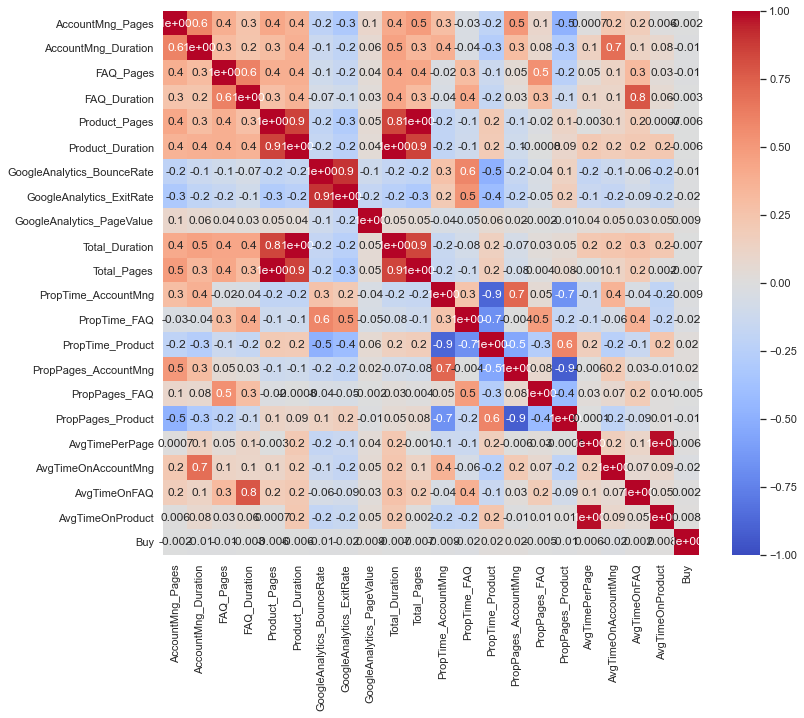

In [52]:
# ------------ Spearman Correlation ------------

# Check correlations

all_train_metric = X_train_metric_scaled.join(y_train)
all_train_metric.head()

corr = all_train_metric.corr(method = 'pearson')  # or spearman

def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, vmin=-1, vmax=1, annot = True, cmap ="coolwarm" , fmt='.1')

    plt.show()
    
cor_heatmap(corr)    

In [53]:
# Better visualization of correlation values (numerical data)

corr.style.applymap(lambda x: 'background-color : green' if x > 0.85 else ('background-color : red' if x < -0.85 else ''))

# Higly correlated variables:
# Product_Pages - Product_Duration
# Product_Pages - Total_Pages
# Product_Duration - Total_Pages
# Product_Duration - Total_Duration
# GoogleAnalytics_BounceRate - GoogleAnalytics_ExitRate
# PropTime_AccountMng - PropTime_Product
# PropPages_AccountMng - PropPages_Product
# AvgTimePerPage - AvgTimeOnProduct

,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,Total_Duration,Total_Pages,PropTime_AccountMng,PropTime_FAQ,PropTime_Product,PropPages_AccountMng,PropPages_FAQ,PropPages_Product,AvgTimePerPage,AvgTimeOnAccountMng,AvgTimeOnFAQ,AvgTimeOnProduct,Buy
AccountMng_Pages,1.000000,0.603926,0.383487,0.257743,0.425978,0.366348,-0.211806,-0.311178,0.100920,0.412732,0.489044,0.291299,-0.032040,-0.205768,0.500469,0.095393,-0.476831,0.000676,0.226532,0.176214,0.006299,-0.001601
AccountMng_Duration,0.603926,1.000000,0.308200,0.246285,0.300756,0.376923,-0.134970,-0.199029,0.063239,0.455967,0.339038,0.380991,-0.039002,-0.270535,0.300818,0.081720,-0.295067,0.143677,0.687569,0.127125,0.081494,-0.014190
FAQ_Pages,0.383487,0.308200,1.000000,0.616673,0.384940,0.390500,-0.108026,-0.158242,0.042477,0.434170,0.422762,-0.024955,0.302990,-0.128352,0.049823,0.545587,-0.234661,0.046787,0.132387,0.317250,0.034995,-0.012412
FAQ_Duration,0.257743,0.246285,0.616673,1.000000,0.285136,0.364124,-0.068857,-0.101444,0.030170,0.430038,0.307888,-0.042982,0.410020,-0.166692,0.030689,0.294658,-0.129968,0.111375,0.108317,0.784499,0.060460,-0.002994
Product_Pages,0.425978,0.300756,0.384940,0.285136,1.000000,0.855866,-0.191380,-0.283991,0.047630,0.847218,0.997177,-0.191659,-0.124763,0.206293,-0.124386,-0.018134,0.120741,-0.002811,0.115762,0.182765,0.000732,-0.006431
Product_Duration,0.366348,0.376923,0.390500,0.364124,0.855866,1.000000,-0.166673,-0.235861,0.043778,0.994186,0.855244,-0.192058,-0.114317,0.201517,-0.102736,-0.000824,0.094839,0.217599,0.181658,0.212837,0.223589,-0.005837
GoogleAnalytics_BounceRate,-0.211806,-0.134970,-0.108026,-0.068857,-0.191380,-0.166673,1.000000,0.901917,-0.114227,-0.172468,-0.200999,0.263035,0.590282,-0.486864,-0.158756,-0.039638,0.137055,-0.177038,-0.126944,-0.060876,-0.179951,-0.014401
GoogleAnalytics_ExitRate,-0.311178,-0.199029,-0.158242,-0.101444,-0.283991,-0.235861,0.901917,1.000000,-0.173503,-0.245024,-0.298022,0.206389,0.527574,-0.413333,-0.188195,-0.046991,0.168387,-0.147366,-0.176205,-0.090886,-0.152113,-0.015419
GoogleAnalytics_PageValue,0.100920,0.063239,0.042477,0.030170,0.047630,0.043778,-0.114227,-0.173503,1.000000,0.048509,0.053892,-0.042321,-0.052940,0.057897,0.017163,-0.002008,-0.013101,0.040236,0.049635,0.029893,0.045094,0.009262
Total_Duration,0.412732,0.455967,0.434170,0.430038,0.847218,0.994186,-0.172468,-0.245024,0.048509,1.000000,0.851470,-0.150085,-0.082766,0.154284,-0.068302,0.026185,0.054685,0.223815,0.236754,0.263435,0.220633,-0.006893


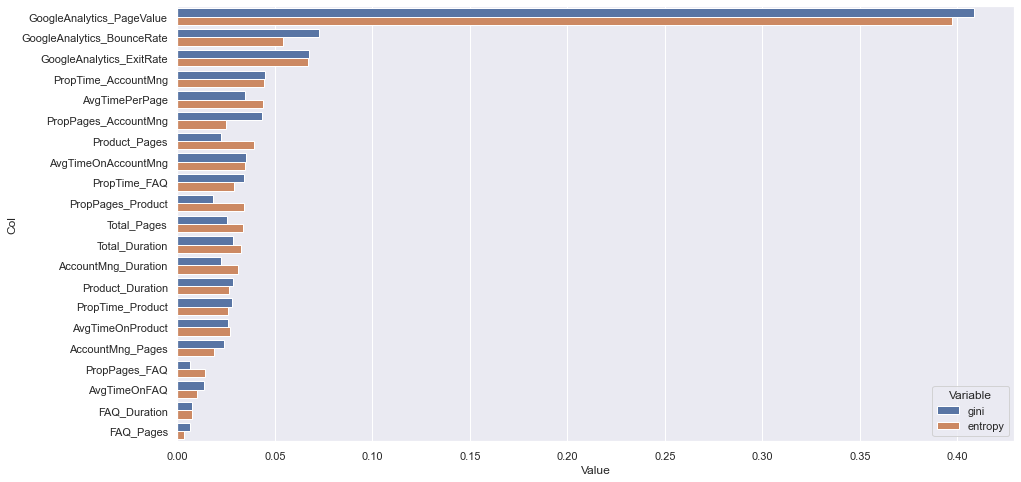

In [54]:
# ------------ Decision Tree ------------

gini_importance = DecisionTreeClassifier().fit(X = X_train_metric_scaled, y = y_train).feature_importances_
entropy_importance = DecisionTreeClassifier(criterion='entropy').fit(X = X_train_metric_scaled, y = y_train).feature_importances_
                                                                     
zippy = pd.DataFrame(zip(gini_importance, entropy_importance), columns = ['gini','entropy'])
zippy['col'] = X_train_metric_scaled.columns
tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)

plt.figure(figsize=(15,8))
sns.barplot(y='Col', x='Value', hue='Variable', data=tidy)
plt.show()

In [60]:
# ------------ Backward Regression  ------------
fold = 1

for train_index, val_index in kf.split(data_metric):
        
        # Data Partition
        X_train, X_val = data_metric.iloc[train_index], data_metric.iloc[val_index]
        y_train, y_val = target.iloc[train_index], target.iloc[val_index]
        
        # Scaling the data with MinMaxScaler
        scaler = MinMaxScaler().fit(X_train)
        
        X_train_metric_scaled = scaler.transform(X_train) # this will return an array
        X_train_metric_scaled = pd.DataFrame(X_train_metric_scaled, columns = X_train.columns)#.set_index(X_train.index)

        X_val_metric_scaled = scaler.transform(X_val)
        X_val_metric_scaled = pd.DataFrame(X_val_metric_scaled, columns = X_val.columns)#.set_index(X_val.index)
        
        
        # CODE FOR BACKWARD REGRESSION
        sfs_backward = SequentialFeatureSelector(LogisticRegression(), n_features_to_select=5, direction="backward")
        sfs_backward.fit(X = X_train_metric_scaled, y = y_train)

        selected_features = pd.Series(sfs_backward.support_, index = X_train_metric_scaled.columns, name=f'Partition {fold}')
        
        if fold == 1:
            # Create empty data frame
            backward_results = pd.DataFrame(index = X_train_metric_scaled.columns)
            
        backward_results = pd.concat((backward_results, selected_features), axis=1)
        
        print('Grão a grão enche a galinha o papo')
        fold+=1
        
        
# Add new column with count of True's        
count_backward_list = []
for index, row in backward_results.iterrows():
    count = 0
    for elem in row:
        if elem == True:
            count+=1
    count_backward_list.append(count)

backward_results['Count'] = count_backward_list 
backward_results.sort_values(by='Count', ascending=False)

Grão a grão enche a galinha o papo
Grão a grão enche a galinha o papo
Grão a grão enche a galinha o papo
Grão a grão enche a galinha o papo
Grão a grão enche a galinha o papo
Grão a grão enche a galinha o papo
Grão a grão enche a galinha o papo
Grão a grão enche a galinha o papo
Grão a grão enche a galinha o papo
Grão a grão enche a galinha o papo


,Partition 1,Partition 2,Partition 3,Partition 4,Partition 5,Partition 6,Partition 7,Partition 8,Partition 9,Partition 10,Count
GoogleAnalytics_ExitRate,True,True,True,True,True,True,True,True,True,True,10
GoogleAnalytics_PageValue,True,True,True,True,True,True,True,True,True,True,10
FAQ_Pages,True,True,True,False,True,False,True,True,True,False,7
PropTime_AccountMng,False,True,False,True,True,False,False,False,False,False,3
AvgTimeOnProduct,False,False,False,False,False,False,False,False,True,True,2
PropTime_Product,False,False,False,True,False,True,False,False,False,False,2
FAQ_Duration,False,True,False,False,False,True,False,False,False,False,2
AvgTimeOnFAQ,False,False,True,False,False,False,False,True,False,False,2
AvgTimeOnAccountMng,False,False,False,True,False,False,False,False,False,True,2
Total_Duration,False,False,False,False,True,False,False,False,True,False,2


In [61]:
# ------------ Forward Regression  ------------
fold = 1

for train_index, val_index in kf.split(data_metric):
        
        # Data Partition
        X_train, X_val = data_metric.iloc[train_index], data_metric.iloc[val_index]
        y_train, y_val = target.iloc[train_index], target.iloc[val_index]
        
        # Scaling the data with MinMaxScaler
        scaler = MinMaxScaler().fit(X_train)
        
        X_train_metric_scaled = scaler.transform(X_train) # this will return an array
        X_train_metric_scaled = pd.DataFrame(X_train_metric_scaled, columns = X_train.columns)#.set_index(X_train.index)

        X_val_metric_scaled = scaler.transform(X_val)
        X_val_metric_scaled = pd.DataFrame(X_val_metric_scaled, columns = X_val.columns)#.set_index(X_val.index)
        
        
        # CODE FOR FORWARD REGRESSION
        sfs_forward = SequentialFeatureSelector(LogisticRegression(), n_features_to_select=5, direction="forward")
        sfs_forward.fit(X = X_train_metric_scaled, y = y_train)

        selected_features = pd.Series(sfs_forward.support_, index = X_train_metric_scaled.columns, name=f'Partition {fold}')
        
        if fold == 1:
            # Create empty data frame
            forward_results = pd.DataFrame(index = X_train_metric_scaled.columns)
            
        forward_results = pd.concat((forward_results, selected_features), axis=1)
        
        print('Grão a grão enche a galinha o papo')
        fold+=1
        
        
# Add new column with count of True's        
count_forward_list = []
for index, row in forward_results.iterrows():
    count = 0
    for elem in row:
        if elem == True:
            count+=1
    count_forward_list.append(count)

forward_results['Count'] = count_forward_list 

forward_results.sort_values(by='Count', ascending=False)


Grão a grão enche a galinha o papo
Grão a grão enche a galinha o papo
Grão a grão enche a galinha o papo
Grão a grão enche a galinha o papo
Grão a grão enche a galinha o papo
Grão a grão enche a galinha o papo
Grão a grão enche a galinha o papo
Grão a grão enche a galinha o papo
Grão a grão enche a galinha o papo
Grão a grão enche a galinha o papo


,Partition 1,Partition 2,Partition 3,Partition 4,Partition 5,Partition 6,Partition 7,Partition 8,Partition 9,Partition 10,Count
GoogleAnalytics_ExitRate,True,True,True,True,True,True,True,True,True,True,10
GoogleAnalytics_PageValue,True,True,True,True,True,True,True,True,True,True,10
AvgTimePerPage,True,True,True,True,False,False,False,True,True,True,7
AvgTimeOnAccountMng,True,True,False,False,False,True,False,True,True,True,6
GoogleAnalytics_BounceRate,False,False,True,False,True,True,True,False,True,True,6
PropTime_AccountMng,True,False,False,False,False,True,True,False,False,False,3
PropTime_FAQ,False,False,False,True,True,False,False,True,False,False,3
PropTime_Product,False,True,False,False,False,False,True,False,False,False,2
PropPages_FAQ,False,False,False,True,True,False,False,False,False,False,2
AvgTimeOnProduct,False,False,True,False,False,False,False,False,False,False,1


In [62]:
# ------------ Select From Model ------------
fold = 1

for train_index, val_index in kf.split(data_metric):
        
        # Data Partition
        X_train, X_val = data_metric.iloc[train_index], data_metric.iloc[val_index]
        y_train, y_val = target.iloc[train_index], target.iloc[val_index]
        
        # Scaling the data with MinMaxScaler
        scaler = MinMaxScaler().fit(X_train)
        
        X_train_metric_scaled = scaler.transform(X_train) # this will return an array
        X_train_metric_scaled = pd.DataFrame(X_train_metric_scaled, columns = X_train.columns)#.set_index(X_train.index)

        X_val_metric_scaled = scaler.transform(X_val)
        X_val_metric_scaled = pd.DataFrame(X_val_metric_scaled, columns = X_val.columns)#.set_index(X_val.index)
        
        
        # CODE FOR SELECT FROM MODEL
        threshold = np.sort(importance)[-3] + 0.01

        sfm = SelectFromModel(lasso, threshold=threshold)
        sfm.fit(X = X_train_metric_scaled, y = y_train)

        selected_features = pd.Series(sfm.get_support(), index = X_train_metric_scaled.columns, name=f'Partition {fold}')
        
        if fold == 1:
            sfm_results = pd.DataFrame(index = X_train_metric_scaled.columns)
            
        sfm_results = pd.concat((sfm_results, selected_features), axis=1)
        
        fold+=1
        
        
# Add new column with count of True's        
count_sfm_list = []
for index, row in sfm_results.iterrows():
    count = 0
    for elem in row:
        if elem == True:
            count+=1
    count_sfm_list.append(count)

sfm_results['Count'] = count_sfm_list 

sfm_results.sort_values(by='Count', ascending=False)

,Partition 1,Partition 2,Partition 3,Partition 4,Partition 5,Partition 6,Partition 7,Partition 8,Partition 9,Partition 10,Count
GoogleAnalytics_PageValue,True,True,True,True,True,True,True,True,True,True,10
Product_Duration,True,False,True,True,False,False,True,False,False,False,4
Product_Pages,True,False,False,False,True,False,False,False,False,True,3
AccountMng_Pages,False,False,False,False,False,False,False,False,False,False,0
PropTime_FAQ,False,False,False,False,False,False,False,False,False,False,0
AvgTimeOnFAQ,False,False,False,False,False,False,False,False,False,False,0
AvgTimeOnAccountMng,False,False,False,False,False,False,False,False,False,False,0
AvgTimePerPage,False,False,False,False,False,False,False,False,False,False,0
PropPages_Product,False,False,False,False,False,False,False,False,False,False,0
PropPages_FAQ,False,False,False,False,False,False,False,False,False,False,0


In [63]:
final_results = pd.DataFrame(index = X_train_metric_scaled.columns)
final_results['Count RFE'] = count_rfe_list
final_results['Count Backward'] = count_backward_list
final_results['Count Forward'] = count_forward_list
final_results['Count SFM'] = count_sfm_list
final_results['Average Importance Lasso'] = importance_lasso_list

#final_results['Keep'] = ['Yes']

final_results

,Count RFE,Count Backward,Count Forward,Count SFM,Average Importance Lasso
AccountMng_Pages,0,0,0,0,0.017973
AccountMng_Duration,0,0,0,0,0.030178
FAQ_Pages,0,7,0,0,0.022378
FAQ_Duration,0,2,0,0,0.002275
Product_Pages,3,1,0,3,0.410036
Product_Duration,3,0,0,4,0.383626
GoogleAnalytics_BounceRate,2,1,6,0,0.065767
GoogleAnalytics_ExitRate,9,10,10,0,0.230845
GoogleAnalytics_PageValue,10,10,10,10,3.184884
Total_Duration,1,2,0,0,0.000000


In [177]:
data_non_metric

,Access_ID,Apple,Windows,Android,Portugal,Iberian_Peninsula,Spain,Returner,New_Access,Covid,...,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,102863333,1,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,103117814,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,103201891,0,1,0,0,0,0,1,0,1,...,0,1,0,0,0,0,0,0,0,0
3,103226087,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,103234445,0,1,0,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,798279589,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
9995,798314158,0,1,0,0,1,1,0,1,1,...,0,0,0,0,0,0,0,1,0,0
9996,798339820,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,798371242,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [178]:
# Chi-Square for categorical data

fold = 1

for train_index, val_index in kf.split(data_non_metric):
        
        # Data Partition
        X_train, X_val = data_non_metric.iloc[train_index], data_non_metric.iloc[val_index]
        y_train, y_val = target.iloc[train_index], target.iloc[val_index]
        
        # CODE FOR Chi-Square
        if fold == 1:
            chi_square_results = pd.DataFrame(index = X_train.columns)
        
        importance_list = []
        
        for var in data_non_metric:
            
            dfObserved = pd.crosstab(y_train,X_train[var]) 
            chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
            dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)

            if p < 0.05:
                importance_list.append(True)
            else: 
                importance_list.append(False)
            
        selected_features = pd.Series(importance_list, index = X_train.columns, name=f'Partition {fold}')    
      
        chi_square_results = pd.concat((chi_square_results, selected_features), axis=1)
        
        fold+=1
        
        
# Add new column with count of True's        
count_chi_square_list = []
for index, row in chi_square_results.iterrows():
    count = 0
    for elem in row:
        if elem == True:
            count+=1
    count_chi_square_list.append(count)

chi_square_results['Count'] = count_chi_square_list 

chi_square_results.sort_values(by='Count', ascending=False)

,Partition 1,Partition 2,Partition 3,Partition 4,Partition 5,Partition 6,Partition 7,Partition 8,Partition 9,Partition 10,Count
Traffic8,True,True,True,True,True,True,True,True,True,True,10
Traffic2,True,True,True,True,True,True,True,True,True,True,10
Windows,True,True,True,True,True,True,True,True,True,True,10
Apple,True,True,True,True,True,True,True,True,True,True,10
Traffic13,True,True,True,True,True,True,True,True,True,True,10
Traffic12,True,True,True,True,True,True,True,True,True,True,10
Traffic3,True,True,True,True,True,True,True,True,True,True,10
Returner,True,True,True,True,True,True,True,True,True,True,10
New_Access,True,True,True,True,True,True,True,True,True,True,10
Covid,True,True,True,True,True,True,True,True,True,True,10


In [181]:
data_select_features = data[['Access_ID','GoogleAnalytics_PageValue', 'GoogleAnalytics_ExitRate', 'Product_Pages', 'PropPages_AccountMng', 'Apple', 'Covid', 'Windows']]
data_select_features

,Access_ID,GoogleAnalytics_PageValue,GoogleAnalytics_ExitRate,Product_Pages,PropPages_AccountMng,Apple,Covid,Windows
0,102863333,0.0000,0.0667,3,0.000000,1,0,0
1,103117814,0.0000,0.0449,23,0.000000,0,1,1
2,103201891,0.0000,0.0583,8,0.000000,0,1,1
3,103226087,42.4225,0.0250,9,0.000000,0,1,1
4,103234445,12.5033,0.0093,36,0.000000,0,1,1
...,...,...,...,...,...,...,...,...
9994,798279589,0.0000,0.0111,23,0.107143,1,1,0
9995,798314158,0.0000,0.0111,3,0.666667,0,1,1
9996,798339820,0.0000,0.0519,27,0.000000,1,0,0
9997,798371242,0.0000,0.0363,53,0.000000,0,1,1


In [182]:
X_train_metric_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8872 entries, 0 to 8871
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AccountMng_Pages            8872 non-null   float64
 1   AccountMng_Duration         8872 non-null   float64
 2   FAQ_Pages                   8872 non-null   float64
 3   FAQ_Duration                8872 non-null   float64
 4   Product_Pages               8872 non-null   float64
 5   Product_Duration            8872 non-null   float64
 6   GoogleAnalytics_BounceRate  8872 non-null   float64
 7   GoogleAnalytics_ExitRate    8872 non-null   float64
 8   GoogleAnalytics_PageValue   8872 non-null   float64
 9   Total_Duration              8872 non-null   float64
 10  Total_Pages                 8872 non-null   float64
 11  PropTime_AccountMng         8872 non-null   float64
 12  PropTime_FAQ                8872 non-null   float64
 13  PropTime_Product            8872 

<a class="anchor" id="15th-bullet">

## Final Insights:
    
</a>

<hr>

### Numerical Data

| Predictor | Spearman | RFE | Lasso | What to do? (One possible way to "solve") | 
| --- | --- | --- | --- |--- |
| AccountMng_Pages | Discard | Keep | Keep ?| Include in the model |
| AccountMng_Duration | Discard | Keep | Keep | Include in the model |
| FAQ_Pages | Discard | Discard | Keep | Try with and without |
| FAQ_Duration | Discard | Discard | Discard |  Discard |
| Product_Pages | Discard | Discard | Discard |  Discard |
| Product_Duration | Discard | Keep | Keep | Include in the model |
| GoogleAnalytics_BounceRate | Discard | Discard | Keep ? | Discard |
| GoogleAnalytics_ExitRate | Discard | Keep | Keep ?| Include in the model |
| GoogleAnalytics_PageValue | Discard | Keep | Keep | Include in the model |
| Total_Duration | Discard | Discard | Discard |  Discard |
| Total_Pages | Discard | Keep | Keep | Include in the model |
| PropTime_AccountMng | Discard | Discard | Discard |  Discard |
| PropTime_FAQ | Discard | Discard | Discard |  Discard |
| PropTime_Product | Discard | Keep | Keep | Include in the model |
| PropPages_AccountMng | Discard | Discard | Keep ? | Discard |
| PropPages_FAQ | Discard | Keep | Keep ?| Include in the model |
| PropPages_Product | Discard | Keep | Keep | Include in the model |
| AvgTimeOnAccountMng | Discard | Discard | Keep | Try with and without |
| AvgTimeOnFAQ | Discard | Discard | Keep | Try with and without |
| AvgTimeOnProduct | Discard | Discard | Keep | Try with and without |
| Month | Discard | Discard | Discard |  Discard | 


<hr>


### Categorical Data

| Predictor | Chi-Square | 
| --- | --- | 
| OS | Keep |  
| Country | Discard | 
| Type_of_Visitor | Keep |

<hr>

In [131]:
# Model Evaluation and selection: (Lab class model selection)

# train/test/split:
# Training dataset, with 60% of the data, that will allow me to build the model;
# Validation dataset, with 20% of the data, that will allow me to fine tune the model and check some problems like overfitting;
# Test dataset, with 20% of the data, that will allow me to evaluate the performance of the final model.


# train/test/split vs K fold vs repeated k fold vs leave one out vs Stratified k-fold
# Ways of splitting the train/val/test datasets


# Model Selection
# Logistic vs Decision Trees vs Naive Bayes vs KNN

# Model Evaluation

In [183]:
def avg_score(method, model, X, y):
    
    score_train = []
    score_val = []
    
    for train_index, test_index in method.split(X):
        
        # iloc vai de linha a linha
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        
        model = model.fit(X_train, y_train)
        
        value_train = model.score(X_train, y_train)
        value_val = model.score(X_val,y_val)
        
        score_train.append(value_train)
        score_val.append(value_val)

    print('Average score of Train:', round(np.mean(score_train), 5))
    print('Average score of Valid:', round(np.mean(score_val), 5))
    print(f'Difference between Train and Validation: {round(np.mean(score_train)-np.mean(score_val), 5)}')

In [190]:
# Change the way to split the dataset
rkf2 = RepeatedKFold(n_splits=6, n_repeats=2)
kf = KFold(n_splits=10)
loo = LeaveOneOut()
#LeavePOut(p=1)


# Change the model to use and its parameters
DT = DecisionTreeClassifier(    
    criterion='entropy',
    splitter='best',
    max_depth=3,
    min_samples_split=2,)

log_model = LogisticRegression()


# Call the function above
avg_score(kf, DT, data_select_features, target)

Average score of Train: 0.8913
Average score of Valid: 0.88719
Difference between Train and Validation: 0.00411


In [191]:
final_model = DT

In [135]:
import sys
#!{sys.executable} -m pip install regressors
from regressors import stats

xlabels = X_train.columns
xlabels
print(log_model.coef_)
print(log_model.intercept_)

# Regression
stats.summary(clf = log_model, X = X_train, y = y_train)#, xlabels = xlabels)

[[ 0.07906306 -5.5157126   0.00684082  1.62217994 -0.35235929  0.53845728
  -0.03477089]]
[-2.93889893]


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1 and the array at index 1 has size 7

In [136]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred)
cm

NameError: name 'y_pred' is not defined

# Performance Measures

In [137]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

In [138]:
def metrics(y_train, pred_train , y_val, pred_val):
    print('___________________________________________________________________________________________________________')
    print('                                                     TRAIN                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train))
    print(confusion_matrix(y_train, pred_train))


    print('___________________________________________________________________________________________________________')
    print('                                                VALIDATION                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val))
    print(confusion_matrix(y_val, pred_val))

In [139]:
labels_train = log_model.predict(X_train)
labels_val = log_model.predict(X_val)

ValueError: X has 46 features per sample; expecting 7

In [140]:
metrics(y_train=y_train, pred_train=labels_train , y_val=y_val, pred_val=labels_val)

NameError: name 'labels_train' is not defined

# Deployment

In [192]:
test = pd.read_csv('test.csv')
test.head()

,Access_ID,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor
0,798519314,24-Aug-20,0,0.00,0,0.0,86,5332.5478,0.0139,0.0654,0.0000,Windows,2,Brazil,1,Returner
1,798663101,25-May-20,2,37.50,0,0.0,55,1420.4725,0.0012,0.0058,0.0000,Android,1,Spain,4,Returner
2,798663221,2-Nov-20,0,0.00,0,0.0,36,788.5000,0.0000,0.0250,0.0000,Windows,6,Spain,3,Returner
3,798760918,14-May-20,0,0.00,0,0.0,2,689.0000,0.0000,0.1000,0.0000,Windows,2,Spain,2,New_Access
4,798856982,5-Nov-20,12,225.25,1,0.0,129,3367.0413,0.0014,0.0185,1.0353,Windows,4,Portugal,10,Returner


In [193]:
test.Access_ID = test.Access_ID.astype('string') 
test.Date = pd.to_datetime(test.Date)
test.OS = test.OS.astype('string') 
test.Country = test.Country.astype('string') 
test.Type_of_Visitor = test.Type_of_Visitor.astype('string') 
test.Type_of_Traffic = test.Type_of_Traffic.astype('string') 
test.Browser = test.Browser.astype('string') 

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2300 entries, 0 to 2299
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Access_ID                   2300 non-null   string        
 1   Date                        2300 non-null   datetime64[ns]
 2   AccountMng_Pages            2300 non-null   int64         
 3   AccountMng_Duration         2300 non-null   float64       
 4   FAQ_Pages                   2300 non-null   int64         
 5   FAQ_Duration                2300 non-null   float64       
 6   Product_Pages               2300 non-null   int64         
 7   Product_Duration            2300 non-null   float64       
 8   GoogleAnalytics_BounceRate  2300 non-null   float64       
 9   GoogleAnalytics_ExitRate    2300 non-null   float64       
 10  GoogleAnalytics_PageValue   2300 non-null   float64       
 11  OS                          2300 non-null   string      

In [194]:
test['Total_Pages'] = test['AccountMng_Pages'] + test['FAQ_Pages'] + test['Product_Pages']
test.loc[test['Total_Pages']==0,'Total_Pages']=1

test['Month'] = test['Date'].dt.month

test['Covid'] = test['Month'].apply(lambda x: str(1) if x>3 else str(0))
test['Apple'] = test['OS'].apply(lambda x: str(1) if x == 'MacOSX' or x == 'iOS' else str(0))  
test['Windows'] = test['OS'].apply(lambda x: str(1) if x == 'Windows' else str(0))  
test['Android'] = test['OS'].apply(lambda x: str(1) if x == 'Android' else str(0))
test['PropPages_AccountMng'] = test['AccountMng_Pages']/test['Total_Pages']

test

,Access_ID,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,...,Country,Type_of_Traffic,Type_of_Visitor,Total_Pages,Month,Covid,Apple,Windows,Android,PropPages_AccountMng
0,798519314,2020-08-24,0,0.00,0,0.000,86,5332.5478,0.0139,0.0654,...,Brazil,1,Returner,86,8,1,0,1,0,0.000000
1,798663101,2020-05-25,2,37.50,0,0.000,55,1420.4725,0.0012,0.0058,...,Spain,4,Returner,57,5,1,0,0,1,0.035088
2,798663221,2020-11-02,0,0.00,0,0.000,36,788.5000,0.0000,0.0250,...,Spain,3,Returner,36,11,1,0,1,0,0.000000
3,798760918,2020-05-14,0,0.00,0,0.000,2,689.0000,0.0000,0.1000,...,Spain,2,New_Access,2,5,1,0,1,0,0.000000
4,798856982,2020-11-05,12,225.25,1,0.000,129,3367.0413,0.0014,0.0185,...,Portugal,10,Returner,142,11,1,0,1,0,0.084507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295,962042726,2020-11-27,10,720.50,2,88.725,220,10580.3448,0.0048,0.0221,...,Portugal,1,Returner,232,11,1,0,1,0,0.043103
2296,962063064,2020-03-20,0,0.00,0,0.000,3,55.0000,0.0667,0.1000,...,Spain,3,Returner,3,3,0,1,0,0,0.000000
2297,962147749,2020-11-22,2,45.50,0,0.000,22,535.0000,0.0000,0.0250,...,Spain,11,Returner,24,11,1,0,1,0,0.083333
2298,962182167,2020-11-19,8,166.70,0,0.000,9,171.7000,0.0167,0.0500,...,Portugal,3,Returner,17,11,1,0,1,0,0.470588


In [195]:
test_select_features = test[['Access_ID','GoogleAnalytics_PageValue', 'GoogleAnalytics_ExitRate', 'Product_Pages', 'PropPages_AccountMng', 'Apple', 'Covid', 'Windows']]
test_select_features

,Access_ID,GoogleAnalytics_PageValue,GoogleAnalytics_ExitRate,Product_Pages,PropPages_AccountMng,Apple,Covid,Windows
0,798519314,0.0000,0.0654,86,0.000000,0,1,1
1,798663101,0.0000,0.0058,55,0.035088,0,1,0
2,798663221,0.0000,0.0250,36,0.000000,0,1,1
3,798760918,0.0000,0.1000,2,0.000000,0,1,1
4,798856982,1.0353,0.0185,129,0.084507,0,1,1
...,...,...,...,...,...,...,...,...
2295,962042726,0.0000,0.0221,220,0.043103,0,1,1
2296,962063064,0.0000,0.1000,3,0.000000,1,0,0
2297,962147749,9.6503,0.0250,22,0.083333,0,1,1
2298,962182167,0.0000,0.0500,9,0.470588,0,1,1


In [196]:
final_model = final_model.fit(data_select_features, target)

test_select_features['Buy'] = final_model.predict(test_select_features)

test_select_features

,Access_ID,GoogleAnalytics_PageValue,GoogleAnalytics_ExitRate,Product_Pages,PropPages_AccountMng,Apple,Covid,Windows,Buy
0,798519314,0.0000,0.0654,86,0.000000,0,1,1,0
1,798663101,0.0000,0.0058,55,0.035088,0,1,0,0
2,798663221,0.0000,0.0250,36,0.000000,0,1,1,0
3,798760918,0.0000,0.1000,2,0.000000,0,1,1,0
4,798856982,1.0353,0.0185,129,0.084507,0,1,1,0
...,...,...,...,...,...,...,...,...,...
2295,962042726,0.0000,0.0221,220,0.043103,0,1,1,0
2296,962063064,0.0000,0.1000,3,0.000000,1,0,0,0
2297,962147749,9.6503,0.0250,22,0.083333,0,1,1,1
2298,962182167,0.0000,0.0500,9,0.470588,0,1,1,0


In [197]:
test_select_features['Buy'].value_counts()

0    2077
1     223
Name: Buy, dtype: int64

In [199]:
sample_submission = test_select_features[['Access_ID', 'Buy']]
sample_submission

,Access_ID,Buy
0,798519314,0
1,798663101,0
2,798663221,0
3,798760918,0
4,798856982,0
...,...,...
2295,962042726,0
2296,962063064,0
2297,962147749,1
2298,962182167,0


In [203]:
# Change name of file
sample_submission.to_csv(r'C:\Users\tsoom\OneDrive\Documentos\IMS - Data Science\Machine Learning\Github Project\Project-Machine-Learning\submissions\DT1.csv', index=False, sep=',')
